All text messages have one of three numbers, which are the label: -1, 0 or 1. Those labels mean:

-1: negative sentiment.

0: neutral sentiment.

1: positive sentiment.

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import spacy

from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

from sklearn.model_selection import train_test_split

In [65]:
#Extract reddit data
reddit_data = pd.read_csv('reddit_Data.csv')
reddit_data.rename(columns = {'clean_comment': 'text'}, inplace = True)

In [66]:
#Extract twitter data
twitter_data = pd.read_csv('Twitter_Data.csv')
twitter_data.rename(columns = {'clean_text': 'text'}, inplace = True)

In [67]:
#Combine both dataframes into one master dataframe
data = pd.concat([reddit_data, twitter_data], ignore_index = True)

In [68]:
data['text'][20501]

nan

FIRST ANALYSIS:

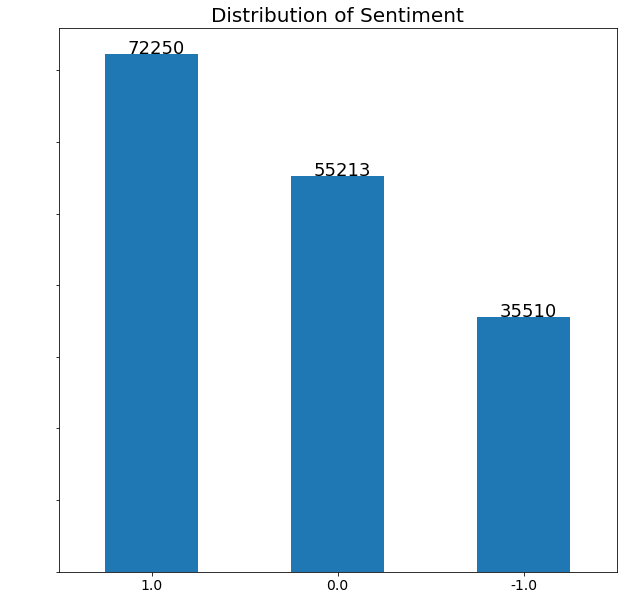

In [69]:
fig , ax = plt.subplots(figsize = (10,10))
ax = twitter_data['category'].value_counts().plot(kind = 'bar')

plt.xticks(rotation = 0, size = 14)
plt.yticks(size = 14, color = 'white')
plt.title('Distribution of Sentiment', size = 20)

ax.annotate(text = twitter_data['category'].value_counts().values[0], xy = (-0.13,twitter_data['category'].value_counts().values[0]), size = 18)
ax.annotate(text = twitter_data['category'].value_counts().values[1], xy = (0.87,twitter_data['category'].value_counts().values[1]), size = 18)
ax.annotate(text = twitter_data['category'].value_counts().values[2], xy = (1.87,twitter_data['category'].value_counts().values[2]), size = 18)

plt.show()

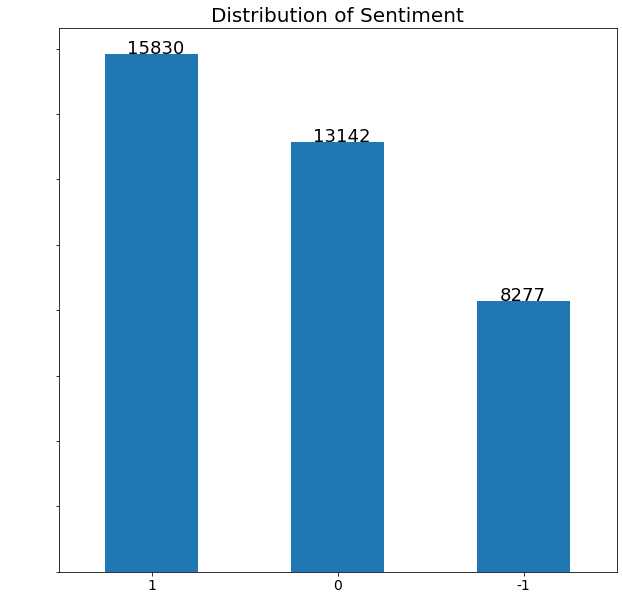

In [70]:
fig , ax = plt.subplots(figsize = (10,10))
ax = reddit_data['category'].value_counts().plot(kind = 'bar')

plt.xticks(rotation = 0, size = 14)
plt.yticks(size = 14, color = 'white')
plt.title('Distribution of Sentiment', size = 20)

ax.annotate(text = reddit_data['category'].value_counts().values[0], xy = (-0.13,reddit_data['category'].value_counts().values[0]), size = 18)
ax.annotate(text = reddit_data['category'].value_counts().values[1], xy = (0.87,reddit_data['category'].value_counts().values[1]), size = 18)
ax.annotate(text = reddit_data['category'].value_counts().values[2], xy = (1.87,reddit_data['category'].value_counts().values[2]), size = 18)

plt.show()

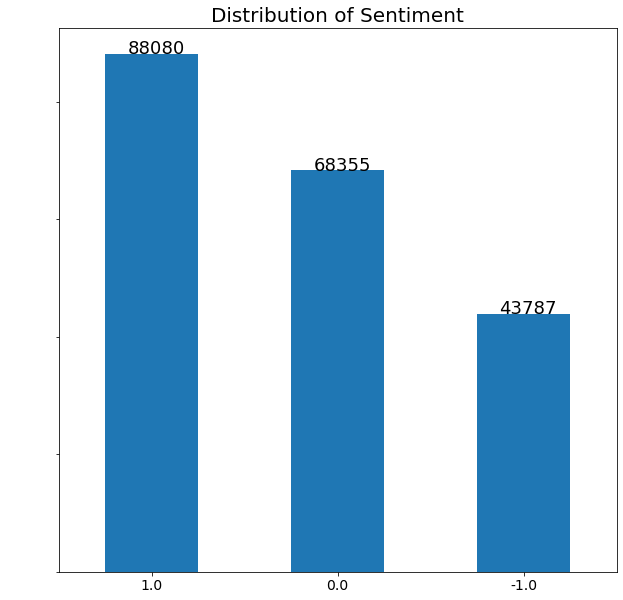

In [71]:
fig , ax = plt.subplots(figsize = (10,10))
ax = data['category'].value_counts().plot(kind = 'bar')

plt.xticks(rotation = 0, size = 14)
plt.yticks(size = 14, color = 'white')
plt.title('Distribution of Sentiment', size = 20)

ax.annotate(text = data['category'].value_counts().values[0], xy = (-0.13,88079), size = 18)
ax.annotate(text = data['category'].value_counts().values[1], xy = (0.87,68253), size = 18)
ax.annotate(text = data['category'].value_counts().values[2], xy = (1.87,43786), size = 18)

plt.show()

In [20]:
# General word cloud

from wordcloud import WordCloud

wordcloud = WordCloud().generate(' '.join(data['text']))
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

TypeError: sequence item 413: expected str instance, float found

In [ ]:
# Specific dataframes based on label

negative_data = data.loc[data['category'] == -1]
neutral_data = data.loc[data['category'] == 0]
positive_data = data.loc[data['category'] == 1]

In [ ]:
negative_data.head()

In [ ]:
neutral_data.head()

In [10]:
positive_data.head()

NameError: name 'positive_data' is not defined

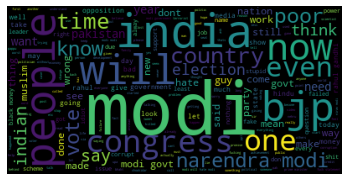

In [134]:
# Negative sentiment's word cloud

from wordcloud import WordCloud

wordcloud_negative = WordCloud().generate(' '.join(negative_data['text']))
# Generate plot
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.show()

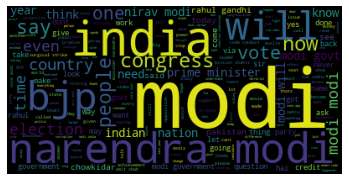

In [135]:
# Neutral sentiment's word cloud

from wordcloud import WordCloud

wordcloud_neutral = WordCloud().generate(' '.join(neutral_data['text']))
# Generate plot
plt.imshow(wordcloud_neutral)
plt.axis("off")
plt.show()

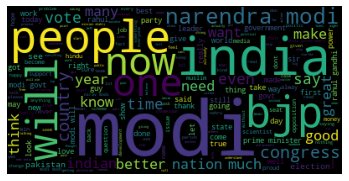

In [137]:
# Positive sentiment's word cloud

from wordcloud import WordCloud

wordcloud_positive = WordCloud().generate(' '.join(positive_data['text']))
# Generate plot
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.show()

### USING SVM

MODEL AND PREDICTION MADE WITH TWITTER DATAFRAME:

In [8]:
twitter_data.isna().sum()

text        4
category    7
dtype: int64

In [9]:
#Drop rows with null values
twitter_data.dropna(axis = 0, inplace = True)

In [10]:
#Checking the shape of the data to ensure nothing is broken
twitter_data.shape

(162969, 2)

In [11]:
# Create a Vectorizer Object using default parameters
hash_vectorizer = HashingVectorizer()

# Convert a collection of text documents to a matrix of token counts
token_count_matrix=hash_vectorizer.fit_transform(twitter_data['text'])
print(f'The size of the count matrix for the texts = {token_count_matrix.get_shape()}')
print(f'The sparse count matrix is as follows:')
print(token_count_matrix)

# Create a tf_idf object using default parameters
tf_idf_transformer=TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 

# Fit to the count matrix, then transform it to a normalized tf-idf representation
twitter_tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)

#print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}')
#print(f'The sparse tf_idf matrix is as follows:')
#print(tf_idf_matrix)

The size of the count matrix for the texts = (162969, 1048576)
The sparse count matrix is as follows:
  (0, 160541)	0.14907119849998599
  (0, 168557)	0.14907119849998599
  (0, 180525)	-0.4472135954999579
  (0, 232512)	0.14907119849998599
  (0, 263274)	0.14907119849998599
  (0, 277794)	-0.14907119849998599
  (0, 286878)	-0.29814239699997197
  (0, 288398)	0.14907119849998599
  (0, 360502)	0.29814239699997197
  (0, 387101)	-0.14907119849998599
  (0, 433698)	0.14907119849998599
  (0, 434864)	0.14907119849998599
  (0, 449993)	-0.14907119849998599
  (0, 465141)	-0.14907119849998599
  (0, 482215)	-0.14907119849998599
  (0, 484920)	-0.14907119849998599
  (0, 490370)	0.29814239699997197
  (0, 522187)	0.14907119849998599
  (0, 614924)	0.14907119849998599
  (0, 646934)	0.14907119849998599
  (0, 747378)	-0.14907119849998599
  (0, 748718)	0.14907119849998599
  (0, 808196)	-0.14907119849998599
  (0, 839641)	-0.14907119849998599
  (0, 865698)	0.14907119849998599
  :	:
  (162968, 257965)	0.16222142113

In [12]:
# Getting X and y

X_twitter = twitter_tf_idf_matrix
y_twitter = twitter_data.category

#Splitting the data into training and testing

X_train_twitter, X_test_twitter, y_train_twitter, y_test_twitter = train_test_split(X_twitter, y_twitter, test_size=0.1)

In [13]:
#Creating, fitting and scoring classifier
twitter_classifier = LinearSVC()
twitter_classifier.fit(X_train_twitter, y_train_twitter)

LinearSVC()

MODEL AND PREDICTION MADE WITH REDDIT DATAFRAME:

In [14]:
reddit_data.isna().sum()

text        100
category      0
dtype: int64

In [15]:
# Drop rows with null values
reddit_data.dropna(axis = 0, inplace = True)

In [16]:
# Create a Vectorizer Object using default parameters
hash_vectorizer = HashingVectorizer()

# Convert a collection of text documents to a matrix of token counts
token_count_matrix=hash_vectorizer.fit_transform(reddit_data['text'])
print(f'The size of the count matrix for the texts = {token_count_matrix.get_shape()}')
print(f'The sparse count matrix is as follows:')
print(token_count_matrix)

# Create a tf_idf object using default parameters
tf_idf_transformer=TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 

# Fit to the count matrix, then transform it to a normalized tf-idf representation
reddit_tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)

#print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}')
#print(f'The sparse tf_idf matrix is as follows:')
#print(tf_idf_matrix)

The size of the count matrix for the texts = (37149, 1048576)
The sparse count matrix is as follows:
  (0, 66497)	0.14002800840280097
  (0, 88541)	0.28005601680560194
  (0, 99311)	0.14002800840280097
  (0, 158803)	-0.28005601680560194
  (0, 176558)	0.14002800840280097
  (0, 180525)	-0.14002800840280097
  (0, 189643)	-0.14002800840280097
  (0, 216640)	-0.14002800840280097
  (0, 246361)	-0.14002800840280097
  (0, 281416)	-0.14002800840280097
  (0, 286878)	-0.28005601680560194
  (0, 298956)	0.14002800840280097
  (0, 331884)	-0.14002800840280097
  (0, 336791)	0.14002800840280097
  (0, 570460)	-0.14002800840280097
  (0, 590295)	-0.14002800840280097
  (0, 636025)	0.14002800840280097
  (0, 639622)	-0.14002800840280097
  (0, 647008)	-0.14002800840280097
  (0, 694840)	0.14002800840280097
  (0, 699224)	-0.14002800840280097
  (0, 720710)	0.14002800840280097
  (0, 770962)	-0.14002800840280097
  (0, 777676)	0.14002800840280097
  (0, 873637)	-0.14002800840280097
  :	:
  (37145, 612207)	-0.2085144140

In [17]:
# Getting X and y

X_reddit = reddit_tf_idf_matrix
y_reddit = reddit_data.category

#Splitting the data into training and testing

X_train_reddit, X_test_reddit, y_train_reddit, y_test_reddit = train_test_split(X_reddit, y_reddit, test_size=0.1)

In [18]:
#Creating, fitting and scoring classifier
reddit_classifier = LinearSVC()
reddit_classifier.fit(X_train_reddit, y_train_reddit)

LinearSVC()

Predictions using both models:

In [19]:
print(f"Accuracy: {twitter_classifier.score(X_test_twitter, y_test_twitter) * 100:.3f}%", )

Accuracy: 94.416%


In [20]:
print(f"Accuracy: {twitter_classifier.score(X_test_reddit, y_test_reddit) * 100:.3f}%", )

Accuracy: 92.705%


In [21]:
print(f"Accuracy: {reddit_classifier.score(X_test_reddit, y_test_reddit) * 100:.3f}%", )

Accuracy: 89.125%


In [22]:
print(f"Accuracy: {reddit_classifier.score(X_test_twitter, y_test_twitter) * 100:.3f}%", )

Accuracy: 85.918%


MODEL AND PREDICTION MADE WITH BOTH DATAFRAMES:

In [73]:
data.isna().sum()

text        104
category      7
dtype: int64

In [74]:
#Drop rows with null values
data.dropna(axis = 0, inplace = True)

In [75]:
#Checking the shape of the data to ensure nothing is broken
data.shape

(200118, 2)

In [76]:
data = data.reset_index() # To reset index from dataframe. If not, it will cause some errors later

In [77]:
data['text'][413]

' htm happy reading '

In [78]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Create a Vectorizer Object using default parameters
hash_vectorizer = HashingVectorizer()

# Convert a collection of text documents to a matrix of token counts
token_count_matrix = hash_vectorizer.fit_transform(data['text'])
#print(f'The size of the count matrix for the texts = {token_count_matrix.get_shape()}')
#print(f'The sparse count matrix is as follows:')
#print(token_count_matrix)

# Create a tf_idf object using default parameters
tf_idf_transformer = TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 

# Fit to the count matrix, then transform it to a normalized tf-idf representation
tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)

#feature_names = hash_vectorizer.get_feature_names()
#dense = tf_idf_matrix.todense()
#denselist = dense.tolist()

print(f'The size of the tf_idf matrix for the texts = {tf_idf_matrix.get_shape()}')
print(f'The sparse tf_idf matrix is as follows:')
print(tf_idf_matrix)

The size of the tf_idf matrix for the texts = (200118, 1048576)
The sparse tf_idf matrix is as follows:
  (0, 1005723)	-0.10434674855047239
  (0, 994433)	0.20921265097415948
  (0, 975831)	-0.07876591237300017
  (0, 949757)	0.10741568289205695
  (0, 930443)	0.07293586296657113
  (0, 927512)	0.24593257824400871
  (0, 905713)	0.11809068666970735
  (0, 901236)	-0.105672412539855
  (0, 899007)	-0.21208407593938183
  (0, 873637)	-0.1901092345355487
  (0, 777676)	0.09861197660578788
  (0, 770962)	-0.24888387265290973
  (0, 720710)	0.18517734322196264
  (0, 699224)	-0.1519147722870182
  (0, 694840)	0.11603906817052086
  (0, 647008)	-0.19963034553967557
  (0, 639622)	-0.20067472298622852
  (0, 636025)	0.1322760125534672
  (0, 590295)	-0.09491272896800283
  (0, 570460)	-0.14735501522285915
  (0, 336791)	0.19736979100171234
  (0, 331884)	-0.07464372128638792
  (0, 298956)	0.2159945766799911
  (0, 286878)	-0.08436432457367855
  (0, 281416)	-0.27657228563153397
  :	:
  (200117, 800174)	-0.260906028

In [27]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(data['text'])

print(tf_idf_matrix)

  (0, 1005723)	-0.10434674855047239
  (0, 994433)	0.20921265097415948
  (0, 975831)	-0.07876591237300017
  (0, 949757)	0.10741568289205695
  (0, 930443)	0.07293586296657113
  (0, 927512)	0.24593257824400871
  (0, 905713)	0.11809068666970735
  (0, 901236)	-0.105672412539855
  (0, 899007)	-0.21208407593938183
  (0, 873637)	-0.1901092345355487
  (0, 777676)	0.09861197660578788
  (0, 770962)	-0.24888387265290973
  (0, 720710)	0.18517734322196264
  (0, 699224)	-0.1519147722870182
  (0, 694840)	0.11603906817052086
  (0, 647008)	-0.19963034553967557
  (0, 639622)	-0.20067472298622852
  (0, 636025)	0.1322760125534672
  (0, 590295)	-0.09491272896800283
  (0, 570460)	-0.14735501522285915
  (0, 336791)	0.19736979100171234
  (0, 331884)	-0.07464372128638792
  (0, 298956)	0.2159945766799911
  (0, 286878)	-0.08436432457367855
  (0, 281416)	-0.27657228563153397
  :	:
  (200117, 800174)	-0.26090602884947744
  (200117, 731192)	0.3393484161726735
  (200117, 730607)	-0.1120668863785222
  (200117, 707819)

In [28]:
print(tf_idf_matrix[0,])#.toarray())

  (0, 1005723)	-0.10434674855047239
  (0, 994433)	0.20921265097415948
  (0, 975831)	-0.07876591237300017
  (0, 949757)	0.10741568289205695
  (0, 930443)	0.07293586296657113
  (0, 927512)	0.24593257824400871
  (0, 905713)	0.11809068666970735
  (0, 901236)	-0.105672412539855
  (0, 899007)	-0.21208407593938183
  (0, 873637)	-0.1901092345355487
  (0, 777676)	0.09861197660578788
  (0, 770962)	-0.24888387265290973
  (0, 720710)	0.18517734322196264
  (0, 699224)	-0.1519147722870182
  (0, 694840)	0.11603906817052086
  (0, 647008)	-0.19963034553967557
  (0, 639622)	-0.20067472298622852
  (0, 636025)	0.1322760125534672
  (0, 590295)	-0.09491272896800283
  (0, 570460)	-0.14735501522285915
  (0, 336791)	0.19736979100171234
  (0, 331884)	-0.07464372128638792
  (0, 298956)	0.2159945766799911
  (0, 286878)	-0.08436432457367855
  (0, 281416)	-0.27657228563153397
  (0, 246361)	-0.2612524319377713
  (0, 216640)	-0.22568083323666
  (0, 189643)	-0.05277197723560065
  (0, 180525)	-0.04789687225911855
  (0,

In [351]:
# NO

dic = dict({})

for i, x in enumerate(tf_idf_matrix):
    print('---------------------------------------------------')
    print(x)
    for j, y in enumerate(x):
        value = tf_idf_matrix[i,j]
        if value != 0.0:
            dic[(i, j)] = tf_idf_matrix[i,j]
            print(j)
    #print(i)

---------------------------------------------------
  (0, 1005723)	-0.10434674855047239
  (0, 994433)	0.20921265097415948
  (0, 975831)	-0.07876591237300017
  (0, 949757)	0.10741568289205695
  (0, 930443)	0.07293586296657113
  (0, 927512)	0.24593257824400871
  (0, 905713)	0.11809068666970735
  (0, 901236)	-0.105672412539855
  (0, 899007)	-0.21208407593938183
  (0, 873637)	-0.1901092345355487
  (0, 777676)	0.09861197660578788
  (0, 770962)	-0.24888387265290973
  (0, 720710)	0.18517734322196264
  (0, 699224)	-0.1519147722870182
  (0, 694840)	0.11603906817052086
  (0, 647008)	-0.19963034553967557
  (0, 639622)	-0.20067472298622852
  (0, 636025)	0.1322760125534672
  (0, 590295)	-0.09491272896800283
  (0, 570460)	-0.14735501522285915
  (0, 336791)	0.19736979100171234
  (0, 331884)	-0.07464372128638792
  (0, 298956)	0.2159945766799911
  (0, 286878)	-0.08436432457367855
  (0, 281416)	-0.27657228563153397
  (0, 246361)	-0.2612524319377713
  (0, 216640)	-0.22568083323666
  (0, 189643)	-0.052771

KeyboardInterrupt: 

In [231]:
dic

{(134, 0): 0.19972066207378492,
 (2264, 0): 0.23826938515189108,
 (4958, 0): 0.05830868774597207,
 (6738, 0): 0.2022260970965284,
 (7423, 0): 0.14836795361976512,
 (9091, 0): 0.03934420503121609,
 (11552, 0): 0.612774032547431,
 (11694, 0): 0.45615891785685514,
 (13146, 0): 0.3352167945249416,
 (14232, 0): 0.6233111073972448,
 (14458, 0): 0.38673521958226564,
 (14958, 0): 0.08933454470851705,
 (17385, 0): 0.06747570410525959,
 (18017, 0): 0.27111813206198027,
 (18705, 0): 0.19397020405685397,
 (28204, 0): 0.213745179766353,
 (29809, 0): 0.12144231927014765,
 (31560, 0): 0.2433535137812938,
 (34860, 0): 0.07400900506056819,
 (35696, 0): 0.3247125438617929,
 (36002, 0): 0.43337948758550293,
 (36116, 0): 0.2955121669651714,
 (36157, 0): 0.3408183301646538,
 (36582, 0): 0.2673841150922058,
 (37473, 0): 0.21358761238432708,
 (45367, 0): 0.3683904991453397,
 (50070, 0): 0.18714951661256163,
 (51554, 0): 0.218233465686041,
 (67564, 0): 0.20897261056347816,
 (70072, 0): 0.25201802699924675,
 (

In [352]:
# Diccionari amb {(fila, columna) = valor}

d = tf_idf_matrix.todok() # convert to dictionary of keys format
dic = dict(d.items())

# We DO NOT need to have indexs whose value is 0.0!!!
for x in dic:
    if dic[x] == 0.0:
        dic = dic.pop(x, None)

In [247]:
#print(dic)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [249]:
dic

{(134, 0): 0.19972066207378492,
 (2264, 0): 0.23826938515189108,
 (4958, 0): 0.05830868774597207,
 (6738, 0): 0.2022260970965284,
 (7423, 0): 0.14836795361976512,
 (9091, 0): 0.03934420503121609,
 (11552, 0): 0.612774032547431,
 (11694, 0): 0.45615891785685514,
 (13146, 0): 0.3352167945249416,
 (14232, 0): 0.6233111073972448,
 (14458, 0): 0.38673521958226564,
 (14958, 0): 0.08933454470851705,
 (17385, 0): 0.06747570410525959,
 (18017, 0): 0.27111813206198027,
 (18705, 0): 0.19397020405685397,
 (28204, 0): 0.213745179766353,
 (29809, 0): 0.12144231927014765,
 (31560, 0): 0.2433535137812938,
 (34860, 0): 0.07400900506056819,
 (35696, 0): 0.3247125438617929,
 (36002, 0): 0.43337948758550293,
 (36116, 0): 0.2955121669651714,
 (36157, 0): 0.3408183301646538,
 (36582, 0): 0.2673841150922058,
 (37473, 0): 0.21358761238432708,
 (45367, 0): 0.3683904991453397,
 (50070, 0): 0.18714951661256163,
 (51554, 0): 0.218233465686041,
 (67564, 0): 0.20897261056347816,
 (70072, 0): 0.25201802699924675,
 (

In [265]:
# NO

word_indices = []
for m in data['text']:
    wl = m.split()
    for w in wl:
        if w not in word_indices:
            word_indices.append(w)

KeyboardInterrupt: 

In [393]:
# List of words with no repetition

words = []
for m in data['text']:
    wl = m.split()
    for w in wl:
        words.append(w)
        #print(w)
print(len(words))
words = np.array(pd.unique(words))
print(words)
print(len(words))

4364855
['family' 'mormon' 'have' ... 'jogiadhiyanath' 'goudi' '“stoic”']
138875


In [368]:
sheep = []
for i, t in enumerate(data['text']):
    if 'sheep' in t.split():
        sheep.append(i)

In [372]:
for s in sheep:
    print(data['text'][s])
    print()

 screenshot case some one the bjp sheep herd decide edit editing wikipedia logged history 

the president going mai mai like sheep wish would either keep quiet read out the oath line line which the ministers then repeat 

this huge two ways this can bjp and modi realise that the whole hindu wimminz need have kids rhetoric ain helping shuts down and doubles down what his govt actually doing well but not the news much thanks the lunatic tards they double down the rhetoric this clear verdict and despite what the bjp might say personally read verdict the rather the loonies around him and saying these loonies are better than the owaisi etc don cut they are not power and with the best mandate any govt has been given the last odd years bjp supporter modi bhakth and one that doesn particularly care for believe aap political entity though this good because knowing modi and shah they will most probably the first this will help the upcoming assembly polls also enough being permanently campaign mo

In [358]:
len(words)

138875

In [367]:
words = np.array(words)
count = (words == 'sheep').sum()
count

47

In [364]:
words

array(['family', 'mormon', 'have', ..., 'that', 'proud', 'for'],
      dtype='<U167')

In [334]:
word_dic = dict({})
for x in dic:
    i = x[0]
    j = x[1]
    #print(i)
    #print(j)
    #print()
    #word_list = data['text'][i].split()
    #print(j)
    #print(word_list)
    ###print('('+str(i)+', '+str(j)+')')
    word = words[j]
    if word in word_dic:
        word_dic[word].append(dic[x])
    else:
        word_dic[word] = [dic[x]]
    

IndexError: index 138878 is out of bounds for axis 0 with size 138875

In [354]:
len(words)

138875

In [355]:
list(dic.keys())[-1]

(61919, 1048574)

In [345]:
indx1 = [x[0] for x in list(dic.keys())]
indx2 = [x[1] for x in list(dic.keys())]

In [346]:
max(indx1)

200117

In [347]:
max(indx2)

1048574

In [373]:
len(indx2)

3819735

In [350]:
1048574 in indx2

True

In [336]:
a = []

for i in range(len(data['text'])):
    a += data['text'][i].split()

In [337]:
a = set(a)

In [338]:
len(a)

138875

In [344]:
data.head(10)

,level_0,index,text,category
0,0,0,family mormon have never tried explain them t...,1.0
1,1,1,buddhism has very much lot compatible with chr...,1.0
2,2,2,seriously don say thing first all they won get...,-1.0
3,3,3,what you have learned yours and only yours wha...,0.0
4,4,4,for your own benefit you may want read living ...,1.0
5,5,5,you should all sit down together and watch the...,-1.0
6,6,6,was teens when discovered zen meditation was ...,1.0
7,7,7,jesus was zen meets jew,0.0
8,8,8,there are two varieties christians dogmatic th...,-1.0
9,9,9,dont worry about trying explain yourself just ...,1.0


In [340]:
len(data['text'])

200118

In [261]:
L = ['have', 'feeling', 'that', 'mgb', 'will', 'win', 'rjd', 'performing', 'way', 'too', 'good', 'rural', 'areas', 'they', 'might', 'get', 'more', 'than']

In [263]:
L[17]

'than'

In [257]:
data['text'][0].split()

['family',
 'mormon',
 'have',
 'never',
 'tried',
 'explain',
 'them',
 'they',
 'still',
 'stare',
 'puzzled',
 'from',
 'time',
 'time',
 'like',
 'some',
 'kind',
 'strange',
 'creature',
 'nonetheless',
 'they',
 'have',
 'come',
 'admire',
 'for',
 'the',
 'patience',
 'calmness',
 'equanimity',
 'acceptance',
 'and',
 'compassion',
 'have',
 'developed',
 'all',
 'the',
 'things',
 'buddhism',
 'teaches']

In [240]:
tf_idf_matrix.toarray()

MemoryError: Unable to allocate 1.53 TiB for an array with shape (200118, 1048576) and data type float64

In [219]:
print(tf_idf_matrix[0,1005723])

-0.10434674855047239


In [234]:
for x in tf_idf_matrix:
    print(x.toarray())
    break

[[0. 0. 0. ... 0. 0. 0.]]


In [31]:
# Getting X and y

X = tf_idf_matrix
y = data.category

#Splitting the data into training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [40]:
#Creating, fitting and scoring classifier
classifier = LinearSVC()
classifier.fit(X_train, y_train)
print(f"Accuracy: {classifier.score(X_test, y_test) * 100:.3f}%", )

TypeError: __init__() got an unexpected keyword argument 'gamma'

In [165]:
classifier.predict(X_test)

array([ 1.,  0.,  0., ..., -1.,  0.,  1.])

In [166]:
print(y_test)

143870    1.0
130986    0.0
80949     0.0
94825     1.0
62451     0.0
         ... 
181414    0.0
141395    1.0
7092     -1.0
177848    0.0
136357    1.0
Name: category, Length: 20012, dtype: float64


In [167]:
type(data['text'])

pandas.core.series.Series

In [168]:
text = pd.Series(['I do it'])

In [169]:
text

0    I do it
dtype: object

In [63]:
classifier.predict(tf_idf_matrix)

array([0.])

In [33]:
# Function that prints which sentiment is expressed in one message

def classify(message):
    text = pd.Series(message)
    hash_vectorizer = HashingVectorizer()
    token_count_matrix=hash_vectorizer.fit_transform(text)
    tf_idf_transformer=TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 
    tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)
    label = int(classifier.predict(tf_idf_matrix)[0])
    if label == -1:
        print('Negative sentiment')
    elif label == 1:
        print('Positive sentiment')
    else:
        print('Neutral sentiment')

In [34]:
# Examples of classification

classify("Oh shit! That's disgusting!")
classify('Fuck the goverment, embrace anarchy.')
print()
classify('I want you to know that I liked it so much')
classify("Donald Trump won the election, and that's fine")
print()
classify('Have you done your homework?')
classify('fslajfldgdiufe hmeior qfewioaehui')

Negative sentiment
Negative sentiment

Positive sentiment
Positive sentiment

Neutral sentiment
Neutral sentiment


In [35]:
classify("I'm afraid because a sheep wants to invade my city")
classify("I love sheeps! They are funny animals!")
classify("A sheep has told me some things which I can't understand")

Negative sentiment
Positive sentiment
Neutral sentiment


In [36]:
classify('I sent you this letter of complaint because the last steel shipment does not match with our order from September 3th. On that date, we placed an order and paid for 75 hardened steel pipes, with 4 inches width and 15 feet long. Today, we received the goods and they have the wrong dimensions as they are 3 inches width instead of 4')
classify("On behalf of myself and all the company, I am especially pleased to congratulate you on your recent nomination as president of the Association. In our opinion, the members' votes have not only made the regard for your own personal prestige clear but also they show the trust that we all hold in you. I hope soon to have the occasion to congratulate you in person and offer you my 100 per cent collaboration.")

Negative sentiment
Positive sentiment


In [38]:
classify('This pasta is fucking good')
classify('This pasta is good shit')

Positive sentiment
Positive sentiment


In [394]:
from sklearn.calibration import CalibratedClassifierCV

clf = CalibratedClassifierCV(classifier)
clf.fit(X_train, y_train)

def predict(message):
    text = pd.Series(message)
    hash_vectorizer = HashingVectorizer()
    token_count_matrix=hash_vectorizer.fit_transform(text)
    tf_idf_transformer=TfidfTransformer(use_idf=True, smooth_idf=True, sublinear_tf=False) 
    tf_idf_matrix = tf_idf_transformer.fit_transform(token_count_matrix)
    return clf.predict_proba(tf_idf_matrix)

In [406]:
predict('hate')

array([[1.00000000e+00, 1.29709261e-10, 3.91503825e-12]])

In [397]:
probs_dict = dict({})
for i, w in enumerate(words):
    probs_dict[w] = predict(w)
    if i % 100 == 0:
        print(str(i)+'     '+str(100*i/len(words))+'%')

0     0.0%
100     0.07200720072007201%
200     0.14401440144014402%
300     0.21602160216021601%
400     0.28802880288028804%
500     0.36003600360036003%
600     0.43204320432043203%
700     0.504050405040504%
800     0.5760576057605761%
900     0.648064806480648%
1000     0.7200720072007201%
1100     0.7920792079207921%
1200     0.8640864086408641%
1300     0.9360936093609361%
1400     1.008100810081008%
1500     1.08010801080108%
1600     1.1521152115211521%
1700     1.2241224122412242%
1800     1.296129612961296%
1900     1.368136813681368%
2000     1.4401440144014401%
2100     1.5121512151215122%
2200     1.5841584158415842%
2300     1.656165616561656%
2400     1.7281728172817281%
2500     1.8001800180018002%
2600     1.8721872187218722%
2700     1.9441944194419443%
2800     2.016201620162016%
2900     2.0882088208820884%
3000     2.16021602160216%
3100     2.232223222322232%
3200     2.3042304230423043%
3300     2.376237623762376%
3400     2.4482448244824484%
3500     2.52025202

In [398]:
probs_dict

{'family': array([[0.03372374, 0.89946228, 0.06681398]]),
 'mormon': array([[0.02361072, 0.92244203, 0.05394725]]),
 'have': array([[0.02674578, 0.9005601 , 0.07269412]]),
 'never': array([[0.08136728, 0.87294112, 0.0456916 ]]),
 'tried': array([[0.07923372, 0.89791234, 0.02285394]]),
 'explain': array([[0.03217437, 0.90029075, 0.06753487]]),
 'them': array([[0.0336872 , 0.90467588, 0.06163692]]),
 'they': array([[0.02119598, 0.92008612, 0.05871791]]),
 'still': array([[0.02958406, 0.93345205, 0.03696389]]),
 'stare': array([[0.02299494, 0.94824472, 0.02876034]]),
 'puzzled': array([[0.01188821, 0.94649352, 0.04161827]]),
 'from': array([[0.03661956, 0.89881183, 0.06456861]]),
 'time': array([[0.02803821, 0.91617978, 0.05578201]]),
 'like': array([[0.02070569, 0.90101768, 0.07827663]]),
 'some': array([[0.04976908, 0.90554972, 0.0446812 ]]),
 'kind': array([[2.72215332e-11, 7.62120934e-11, 1.00000000e+00]]),
 'strange': array([[9.22015921e-01, 2.51010782e-06, 7.79815688e-02]]),
 'creat

In [429]:
dict_negative = dict({})
dict_neutral = dict({})
dict_positive = dict({})
for w in probs_dict:
    dict_negative[w] = probs_dict[w][0][0]
    dict_neutral[w] = probs_dict[w][0][1]
    dict_positive[w] = probs_dict[w][0][2]

In [430]:
ordered_negative = {k: v for k, v in sorted(dict_negative.items(), key=lambda item: item[1], reverse=True)}
ordered_neutral = {k: v for k, v in sorted(dict_neutral.items(), key=lambda item: item[1], reverse=True)}
ordered_positive = {k: v for k, v in sorted(dict_positive.items(), key=lambda item: item[1], reverse=True)}

In [431]:
num_words = 50

negative_words = list(ordered_negative.keys())[:num_words]
neutral_words = list(ordered_neutral.keys())[:num_words]
positive_words = list(ordered_positive.keys())[:num_words]

negative_values = list(ordered_negative.values())[:num_words]
neutral_values = list(ordered_neutral.values())[:num_words]
positive_values = list(ordered_positive.values())[:num_words]

In [434]:
#alphabet = 'abcdefghijklmnopqrstuvwxyz'

num_words_only = 10


negative_words_only = [w for w in negative_words if w.isalpha()]
neutral_words_only = [w for w in neutral_words if w.isalpha()]
positive_words_only = [w for w in positive_words if w.isalpha()]

negative_words_only = negative_words_only[:num_words_only]
neutral_words_only = neutral_words_only[:num_words_only]
positive_words_only = positive_words_only[:num_words_only]

negative_values_only = [dict_negative[w] for w in negative_words_only]
neutral_values_only = [dict_neutral[w] for w in neutral_words_only]
positive_values_only = [dict_positive[w] for w in positive_words_only]

negative_ordered_dict = dict({k: v for k, v in zip(negative_words_only, negative_values_only)})
neutral_ordered_dict = dict({k: v for k, v in zip(neutral_words_only, neutral_values_only)})
positive_ordered_dict = dict({k: v for k, v in zip(positive_words_only, positive_values_only)})

In [435]:
negative_ordered_dict

{'hate': 0.9999999998663757,
 'stupid': 0.9999999995965579,
 'bloody': 0.9999999680733428,
 'failed': 0.9999999614953413,
 'poor': 0.9999999409745859,
 'bad': 0.9999999293172092,
 'dangerous': 0.9999999033685164,
 'fake': 0.9999998921371086,
 'macaroni': 0.9999998921371086,
 'wrong': 0.9999998762493417}

In [436]:
neutral_ordered_dict

{'modi': 0.9966872057265197}

In [437]:
positive_ordered_dict

{'best': 0.9999999999999986,
 'great': 0.9999999999999984,
 'more': 0.9999999999999947,
 'rabbis': 0.9999999999999947,
 'own': 0.9999999999999704,
 'proud': 0.9999999999998392,
 'good': 0.9999999999995902,
 'many': 0.9999999999971934,
 'better': 0.9999999999905572,
 'successfully': 0.9999999999827682}

In [438]:
neutral_words # Modi --> President de la Índia

['modi',
 'modi’',
 '“modi',
 'modi”',
 'modi®',
 'modi\\',
 'modi…',
 '‘modi’',
 '‘modi',
 '“modi’',
 'modi❔❓',
 'modi—',
 'modi☺️',
 '“modi”',
 'modi،',
 'modi✌',
 '✅modi',
 'modi☺☺☺☺☺☺☺',
 '“——modi',
 'modi☠',
 'modi❤',
 '‘’modi',
 '✌✌modi',
 'modi‘',
 'modi@',
 '●modi',
 '•modi',
 'modi✌️',
 'modi\u200d♂️',
 'modi☝️',
 '⃣modi’',
 '’modi’',
 'modi°',
 'modi❤️❤️❤️',
 'modi√',
 'modi\u2066',
 '⚡modi',
 'modi☺☺☺☺☺',
 'modi✌✌',
 'modi❣️',
 'modi☺',
 '◆modi',
 'modi।',
 '”modi',
 'modi‼️',
 'modi♥️',
 'modi☕',
 'modi✊',
 'modi⭐⭐⭐',
 'modi❓']

In [423]:
negative_words_only

['best',
 'great',
 'more',
 'rabbis',
 'own',
 'lol',
 'proud',
 'many',
 'good',
 'most']

In [424]:
neutral_words_only

['new',
 'right',
 'good',
 'other',
 'down',
 'live',
 'first',
 'best',
 'great',
 'true']

In [425]:
positive_words_only

['lattersuppose',
 'worst',
 'hate',
 'bachaoo',
 'govtdone',
 'pathetic',
 'stupid',
 'chur',
 'disgusting',
 'jele']

In [418]:
'he' in alphabet

False

In [421]:
'he'.isalpha()

True

In [439]:
negative_words

['hate',
 '‘hate',
 '“hate',
 'hate”',
 'stupid',
 '“stupid”',
 'stupid’',
 'bloody',
 'failed',
 '‘failed’',
 '‘failed',
 'failed’',
 'failed”',
 '“failed',
 'poor',
 '“poor”',
 'poor’',
 'poor।',
 'poor”',
 '“poor',
 'bad',
 'bad”',
 '’bad',
 'dangerous',
 'fake',
 'macaroni',
 '“fake”',
 '‘fake',
 '“fake',
 'wrong',
 'wrong\\',
 'wrong”',
 'wrong’',
 '‘wrong’',
 '“wrong',
 '️wrong',
 'evil',
 'evil’',
 '“evil',
 'moron',
 'disgusting',
 'disappointed',
 'idiots',
 'base',
 'mishandled',
 'insulting',
 'badly',
 'idiot',
 'stupidity',
 'stupidity”']

In [440]:
neutral_words

['modi',
 'modi’',
 '“modi',
 'modi”',
 'modi®',
 'modi\\',
 'modi…',
 '‘modi’',
 '‘modi',
 '“modi’',
 'modi❔❓',
 'modi—',
 'modi☺️',
 '“modi”',
 'modi،',
 'modi✌',
 '✅modi',
 'modi☺☺☺☺☺☺☺',
 '“——modi',
 'modi☠',
 'modi❤',
 '‘’modi',
 '✌✌modi',
 'modi‘',
 'modi@',
 '●modi',
 '•modi',
 'modi✌️',
 'modi\u200d♂️',
 'modi☝️',
 '⃣modi’',
 '’modi’',
 'modi°',
 'modi❤️❤️❤️',
 'modi√',
 'modi\u2066',
 '⚡modi',
 'modi☺☺☺☺☺',
 'modi✌✌',
 'modi❣️',
 'modi☺',
 '◆modi',
 'modi।',
 '”modi',
 'modi‼️',
 'modi♥️',
 'modi☕',
 'modi✊',
 'modi⭐⭐⭐',
 'modi❓']

In [441]:
positive_words

['best',
 '‘best',
 '“best',
 'best’',
 'best“',
 'great',
 '️great',
 '‘great',
 '“great',
 '”great',
 'great☺️',
 'more',
 '“more',
 'rabbis',
 'more”',
 'more@',
 'more’',
 'more\u200d♀️\u200d♀️',
 'more✌️',
 'more✌✌✌',
 'more⛳',
 'own',
 'own’',
 'proud',
 '“proud”',
 '⚡proud',
 '“proud',
 '‘proud',
 'proud✌️',
 'good',
 '‘good',
 '“good',
 'good”',
 '“good”',
 'many',
 '“many',
 'better',
 '‘better',
 'successfully',
 'successful',
 'lol',
 'lol☺️',
 'aside…more',
 'win',
 'win✌️',
 'win–win',
 '“win',
 'win”',
 'win…',
 'win’']

### PCA to make a useful word cloud

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Create a PCA model with 2 components: pca
pca = PCA(n_components=2)

# Fit the PCA instance to the scaled samples
pca.fit(tf_idf_matrix)

# Transform the scaled samples: pca_features
pca_features = pca.transform(tf_idf_matrix)

# Print the shape of pca_features
print(pca_features.shape)

In [188]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.csr import csr_matrix

svd = TruncatedSVD(n_components=10, random_state=42)
pca_data = svd.fit_transform(tf_idf_matrix)
pca_data = csr_matrix(pca_data) # Per tornar al format d'abans
#pca_data = pd.DataFrame(pca_data)

In [190]:
print(pca_data)

  (0, 0)	0.15260927923603623
  (0, 1)	-0.03065047127556388
  (0, 2)	-0.05043711379571014
  (0, 3)	-0.06708813831155652
  (0, 4)	-0.025795267390161684
  (0, 5)	-0.040699328750300766
  (0, 6)	-0.044048707640803896
  (0, 7)	0.036986593375187685
  (0, 8)	0.002943124225911407
  (0, 9)	0.01903158321785098
  (1, 0)	0.238279677717613
  (1, 1)	-0.01031924575971235
  (1, 2)	-0.09102082699959482
  (1, 3)	-0.04307541076585444
  (1, 4)	-0.11632069780823324
  (1, 5)	-0.024982986969068234
  (1, 6)	-0.05877826540560366
  (1, 7)	0.019769549972248602
  (1, 8)	0.02548038322542966
  (1, 9)	-0.05525647341791845
  (2, 0)	0.3062852862632073
  (2, 1)	0.2371058846669382
  (2, 2)	-0.16237250875287462
  (2, 3)	-0.009657801440016826
  (2, 4)	0.05634781946464486
  :	:
  (200115, 5)	0.011068542337939717
  (200115, 6)	0.03859791546282461
  (200115, 7)	0.004139101445875515
  (200115, 8)	-0.015653729132186562
  (200115, 9)	-0.05117411572375391
  (200116, 0)	0.11175881256774625
  (200116, 1)	-0.004652784320564356
  (20

In [242]:
pca_data.toarray()

array([[ 0.15260928, -0.03065047, -0.05043711, ...,  0.03698659,
         0.00294312,  0.01903158],
       [ 0.23827968, -0.01031925, -0.09102083, ...,  0.01976955,
         0.02548038, -0.05525647],
       [ 0.30628529,  0.23710588, -0.16237251, ...,  0.05352451,
         0.05989975, -0.06088689],
       ...,
       [ 0.06702788,  0.1024184 , -0.06049362, ...,  0.0041391 ,
        -0.01565373, -0.05117412],
       [ 0.11175881, -0.00465278,  0.05927031, ...,  0.06341776,
        -0.07619107, -0.00352229],
       [ 0.20668181,  0.05997988, -0.00821897, ..., -0.00075542,
        -0.02650965,  0.00663044]])

In [182]:
type(tf_idf_matrix)

scipy.sparse.csr.csr_matrix

In [194]:
print(token_count_matrix)

  (0, 66497)	0.14002800840280097
  (0, 88541)	0.28005601680560194
  (0, 99311)	0.14002800840280097
  (0, 158803)	-0.28005601680560194
  (0, 176558)	0.14002800840280097
  (0, 180525)	-0.14002800840280097
  (0, 189643)	-0.14002800840280097
  (0, 216640)	-0.14002800840280097
  (0, 246361)	-0.14002800840280097
  (0, 281416)	-0.14002800840280097
  (0, 286878)	-0.28005601680560194
  (0, 298956)	0.14002800840280097
  (0, 331884)	-0.14002800840280097
  (0, 336791)	0.14002800840280097
  (0, 570460)	-0.14002800840280097
  (0, 590295)	-0.14002800840280097
  (0, 636025)	0.14002800840280097
  (0, 639622)	-0.14002800840280097
  (0, 647008)	-0.14002800840280097
  (0, 694840)	0.14002800840280097
  (0, 699224)	-0.14002800840280097
  (0, 720710)	0.14002800840280097
  (0, 770962)	-0.14002800840280097
  (0, 777676)	0.14002800840280097
  (0, 873637)	-0.14002800840280097
  :	:
  (200117, 257965)	0.16222142113076254
  (200117, 286878)	-0.16222142113076254
  (200117, 338809)	0.16222142113076254
  (200117, 372

### USING XG BOOST

In [ ]:
import xgboost

In [ ]:
twitter_classifier = xgboost.XGBClassifier()
twitter_classifier.fit(X_train_twitter, y_train_twitter)

In [ ]:
#Creating, fitting and scoring classifier
reddit_classifier = XGBClassifier()
reddit_classifier.fit(X_train_reddit, y_train_reddit)

In [ ]:
#Creating, fitting and scoring classifier
twitter_classifier = SVC()
twitter_classifier.fit(X_train_twitter, y_train_twitter, kernel='poly')

### USING SOME OTHER MODELS

In [471]:
from sklearn.cluster import KMeans

#Creating, fitting and scoring classifier
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_train)
print(f"Accuracy: {kmeans.score(X_test, y_test) * 100:.3f}%", )

Accuracy: -1955335.436%


In [452]:
print(X_train)

  (0, 858264)	-0.13929870159741634
  (0, 728023)	-0.2450631301944143
  (0, 637526)	0.34393878111827536
  (0, 567271)	0.21762088259081958
  (0, 548057)	0.5564603199815092
  (0, 540361)	-0.26070212074403504
  (0, 527645)	0.2073675428053206
  (0, 448693)	0.26004584914379975
  (0, 433698)	0.060139326524040984
  (0, 416181)	-0.172541165784257
  (0, 303491)	-0.29932944189074395
  (0, 286878)	-0.16974006972570102
  (0, 93490)	-0.2624312709780699
  (0, 11631)	-0.21443228485988133
  (1, 1035167)	0.1291416957772664
  (1, 993794)	0.14540564698381603
  (1, 930443)	0.10300537518372545
  (1, 926068)	0.0893942599163441
  (1, 864211)	-0.2339868375942997
  (1, 832412)	0.17580313674746842
  (1, 809346)	0.2750636280790582
  (1, 795300)	-0.39059566704453474
  (1, 746795)	-0.1984785930748031
  (1, 734595)	-0.13302098271911525
  (1, 725201)	0.27624165058940187
  :	:
  (180104, 1042230)	0.2957491280120315
  (180104, 1008391)	-0.3003411394928579
  (180104, 952279)	-0.2472714530479679
  (180104, 926068)	0.1501

In [472]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print(f"Accuracy: {knn.score(X_test, y_test) * 100:.3f}%", )

Accuracy: 39.891%


In [ ]:
# ATENCIÓ! TRIGA EXAGERADAMENT MASSA (O INFINIT)

svc1 = SVC(kernel='poly')
svc1.fit(X_train, y_train)
print(f"Accuracy: {svc1.score(X_test, y_test) * 100:.3f}%", )

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
print(f"Accuracy: {lr.score(X_test, y_test) * 100:.3f}%", )

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
print(f"Accuracy: {rf.score(X_test, y_test) * 100:.3f}%", )

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print(f"Accuracy: {xgb.score(X_test, y_test) * 100:.3f}%", )

In [41]:
mensaje = 'Fuck you'

classify(mensaje)

Negative sentiment


In [79]:
classifier = LinearSVC()
classifier.fit(X_train, y_train)
print(f"Accuracy: {classifier.score(X_test, y_test) * 100:.3f}%", )

Accuracy: 94.553%


In [49]:
# Hiperparametric search

C_start, C_end, C_step = -3, 11, 0.5
# Generate grid search values for C, gamma
C_val = 2. ** np.arange(C_start, C_end + C_step, C_step)

In [50]:
C_val

array([1.25000000e-01, 1.76776695e-01, 2.50000000e-01, 3.53553391e-01,
       5.00000000e-01, 7.07106781e-01, 1.00000000e+00, 1.41421356e+00,
       2.00000000e+00, 2.82842712e+00, 4.00000000e+00, 5.65685425e+00,
       8.00000000e+00, 1.13137085e+01, 1.60000000e+01, 2.26274170e+01,
       3.20000000e+01, 4.52548340e+01, 6.40000000e+01, 9.05096680e+01,
       1.28000000e+02, 1.81019336e+02, 2.56000000e+02, 3.62038672e+02,
       5.12000000e+02, 7.24077344e+02, 1.02400000e+03, 1.44815469e+03,
       2.04800000e+03])

In [54]:
from sklearn.model_selection import GridSearchCV

lsvc = LinearSVC()
linear_SVC_params = {'C': C_val}
grid_search = GridSearchCV(lsvc , linear_SVC_params, n_jobs = 100)
grid_search.fit(X_train, y_train, cv = StratifiedKFold(y_train,10, indices = True))
y_true, y_pred = Y[test], grid_search.predict(X[test])                   
print(grid_search.best_estimator)


NameError: name 'StratifiedKFold' is not defined

In [ ]:
print "Tuned for  with optimal value: %0.3f" % f1_score(y_true, y_pred)
print classification_report(y_true, y_pred)

print "Grid scores:"
pprint(grid_search.grid_scores_)

print "Best score: %0.3f" % grid_search.best_score


best_parameters = grid_search.best_estimator._get_params()
print "Best C: %0.3f " % best_parameters['C']

In [107]:
C_start, C_end, C_step = -3, 10, 1
# Generate grid search values for C, gamma
C_val = 2. ** np.arange(C_start, C_end + C_step, C_step)
#C_val = np.array([1.0])
#C_val = [C_val[-1]]
print(C_val)
lsvc_params = {'C': C_val}

[1.250e-01 2.500e-01 5.000e-01 1.000e+00 2.000e+00 4.000e+00 8.000e+00
 1.600e+01 3.200e+01 6.400e+01 1.280e+02 2.560e+02 5.120e+02 1.024e+03]


In [103]:
from sklearn.model_selection import GridSearchCV
import time

t1 = time.time()

lsvc = LinearSVC()
grid_search = GridSearchCV(estimator = lsvc, param_grid = lsvc_params,
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

t2 = time.time()

t = t2 - t1

print(t)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
477.10852003097534


C:\Users\sergi\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [108]:
from sklearn import metrics

best_grid = grid_search.best_estimator_
y = best_grid.predict(X_test)
grid_accuracy = metrics.accuracy_score(y_test, y)
grid_accuracy

0.87027783330002

In [109]:
base_accuracy = classifier.score(X_test, y_test)
print('Millora un {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Millora un -7.96%.
